In [8]:
from matplotlib import pyplot as plt
import keras
from keras import layers
from credo import load_data
import numpy as np


original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2
batch_size = 32

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [9]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [10]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [11]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [12]:
(x_train, y_train), (x_test, y_test) = load_data(use_worms=True, use_dots=False, use_tracks=True)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
2449/2449 [==============================] - 18s 7ms/step - loss: 32.5410 - val_loss: 19.3587
Epoch 2/100
2449/2449 [==============================] - 19s 8ms/step - loss: 18.7885 - val_loss: 18.7808
Epoch 3/100
2449/2449 [==============================] - 21s 8ms/step - loss: 18.4627 - val_loss: 18.4119
Epoch 4/100
2449/2449 [==============================] - 19s 8ms/step - loss: 18.1342 - val_loss: 17.7819
Epoch 5/100
2449/2449 [==============================] - 16s 7ms/step - loss: 17.6852 - val_loss: 17.3127
Epoch 6/100
2449/2449 [==============================] - 16s 7ms/step - loss: 17.4245 - val_loss: 17.2344
Epoch 7/100
2449/2449 [==============================] - 17s 7ms/step - loss: 17.3002 - val_loss: 17.1247
Epoch 8/100
2449/2449 [==============================] - 16s 7ms/step - loss: 17.2143 - val_loss: 16.9905
Epoch 9/100
2449/2449 [==============================] - 18s 7ms/step - loss: 17.1597 - val_loss: 16.9673
Epoch 10/100
2449/2449 [======================

112/112 [==============================] - 0s 2ms/step


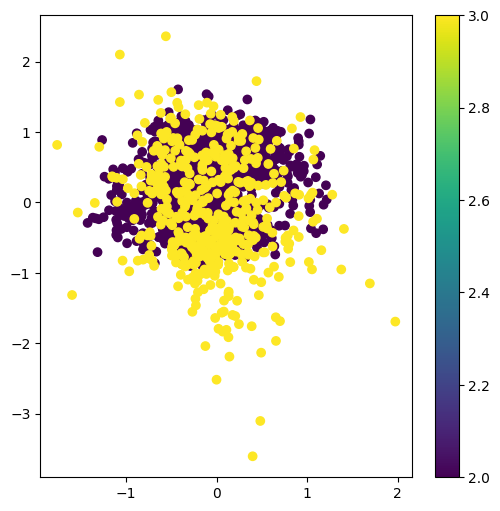

In [13]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[-1][:, 0], x_test_encoded[-1][:, 1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 19ms/step


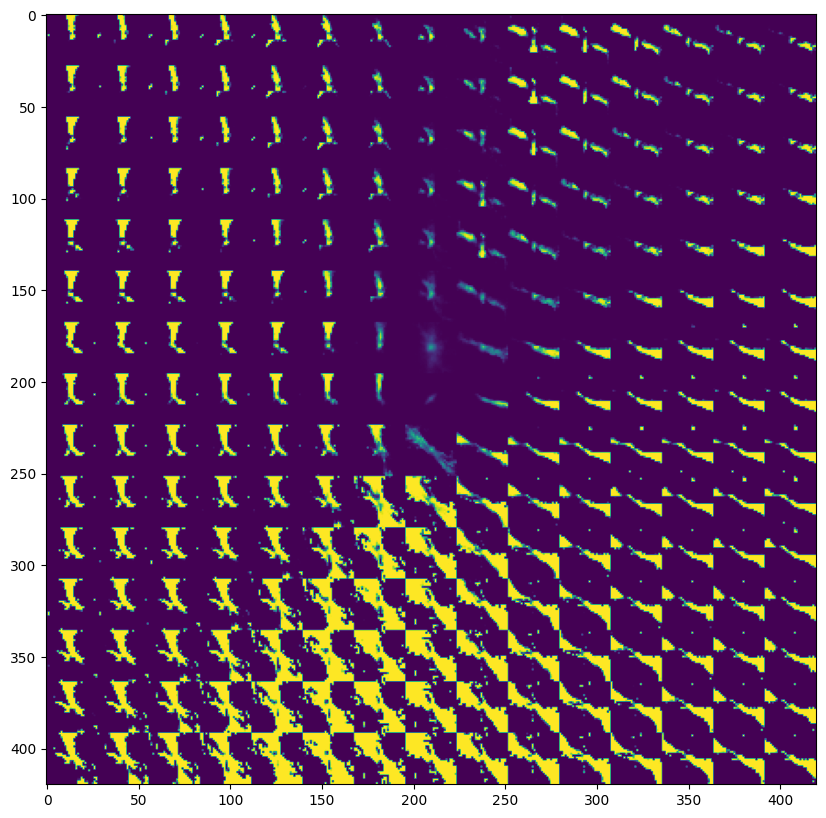

In [14]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()